# **AFL Agent Tutorial: Notebook 02** <a href="https://colab.research.google.com/github/martintb/AFL-tutorial/blob/main/notebooks/02-sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Decision Pipelines (AI agents) with scikit-learn

*Author: Tyler Martin - tyler.martin@nist.gov*


## Learning Goals

This notebook will introduce the following concepts

- chaining a series of analyses into a "decision pipeline"
- active leraning loops for phase boundary identification
- learn about scikit-learn's machine learning tools 


# Setup

**This may take several minutes to complete, please run ASAP**

Please run this collapsed cell by clicking in the box to the left of *8 cells hidden*. This will `pip install` and `import` all necessary dependencies for this tutorial. There is not need to expand this cell block, but you can if you're interested in looking under the hood.


If you've never used Google Colab before, [this FAQ](https://research.google.com/colaboratory/faq.html) may be useful to skim. It's very similar (and based off of) Jupyter, but divergent in several ways.

**Warning!**

If you disconnect for too long, you'll have to rerun this cell. Any text you type into this notebooks should always be saved, but variables in memory and files can dissappear when you disconnect.

You're free to download this notebook and run it locally if you're inclined, but we will provide no support for this.


In [ ]:
!git clone https://github.com/martintb/AFL-tutorial

In [ ]:
!pip install --find-links ./AFL-tutorial/wheels --editable ./AFL-tutorial/

In [ ]:
import sys
sys.path.insert(0,'./AFL-tutorial')

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
import os

import sklearn.cluster
from sklearn.metrics import pairwise
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern

import plotly.express as px
import plotly.graph_objects as go

import xarray as xr
xr.set_options(display_expand_data=False)

In [ ]:
from AFL.double_agent_tutorial import *
from AFL.double_agent_tutorial.instruments.tutorial import *

In [ ]:
np.random.seed(240424)

# Decision Pipeline for Phase Boundary Discovery

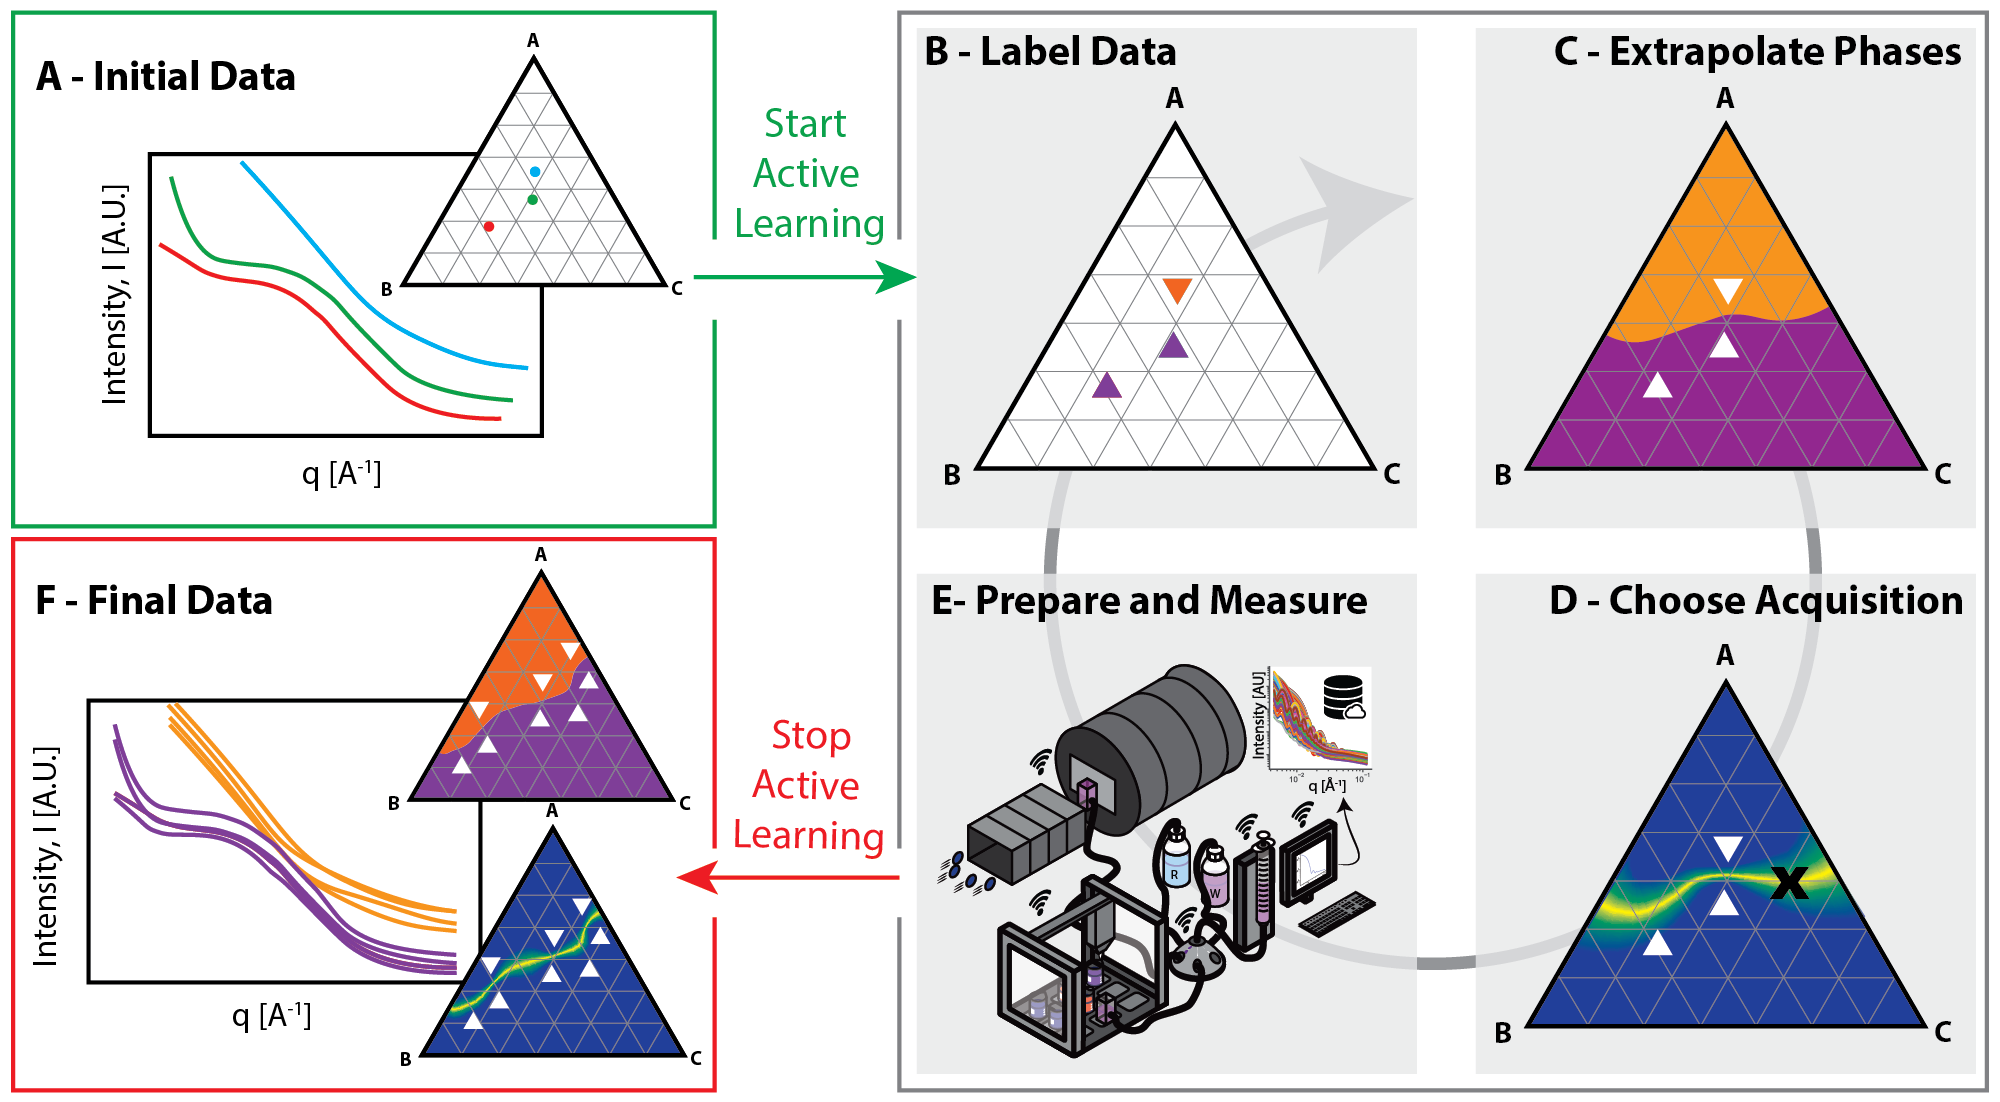



The active learning loop we'll employ consists of several key steps: (A) First, we gather an initial dataset by making at least two measurements at random or expert-selected compositions. (B) Each measurement is then labeled with a phase identity, which could be a descriptive label like "cylinders" or "spheres", or simply a numerical label like "group 0" or "group 1". (C) Using a Gaussian process approach, we extrapolate these labeled measurements across the entire composition space to predict phase boundaries. (D) Based on an acquisition function that evaluates the model's uncertainty, we determine the optimal composition to measure next. (E) Finally, we use our real or virtual instrument to synthesize and characterize a sample at this new composition, feeding the result back into the loop. 


# Make Starting Dataset


Okay, the first step in the active learning loop is to gather some starting data.L et's build a starting dataset by 'measuring' at several compositions. Feel free to edit the list below to change which points the active learning code starts with.

In [ ]:
instrument = get_virtual_instrument()
instrument

In [ ]:
composition_list = [
    {'a':1/3,'b':1/3,'c':1/3},
    {'a':0.0,'b':0.5,'c':0.5},
    {'a':0.5,'b':0.0,'c':0.5},
    {'a':0.5,'b':0.5,'c':0.0},
]

input_dataset = instrument.measure_multiple(composition_list)
input_dataset

Note that the above code output a dataset with multiple entries in the **sample** dimension. Since the sample dimension does not have a coordinate defined for it, you can index it using integer indices.

Below we show how to plot the **sas** data variable.

In [ ]:
input_dataset.sas.plot.line(
    x='q',
    xscale='log',
    yscale='log',
    marker='.',
    ls='none',
)

We can also plot the compositions using the `plot_ternary` helper function. Remember to double-click the ternary to view the compositions along the edges.

In [ ]:
plot_ternary(input_dataset,components=['c','a','b'],include_surface=False)

As an aside, if you want to gather multiple `Dataset` variables into a single `DataArray` you can do so using `.to_array()`. Below, we gather the composition variables and covert them using this method

In [ ]:
input_dataset[['c','a','b']].to_array()

Notice that we now have a second "variable" dimension. You can choose the name of this dimension by passing a keyword argument to the `.to_array()` method.

Its common that we want the first dimension to be the **sample** dimension so we can add a transpose to complete the transform

In [ ]:
input_dataset[['c','a','b']].to_array().transpose('sample',...)

# An Active Learning Loop: Step by Step

In the following section, you will define the three functions that make up the 'brain' of your active learning agent. Each of the functions will take in a `xarray.Dataset`, add variables and attributes, and the return the dataset so it can be passed to the next function.

The order of calling is *Label* -> *Extrapolate* -> *Choose Acquisition*. The same `xarray.Dataset` is passed to each method in order, so your goal is to modify the data put into this dataset.



## Label Method

The *label* function needs to create the *labels* variable which defines the phase identity of each measurement and the *n_phases* attribute which identifies the number of phases.

In [ ]:
def label( dataset: xr.Dataset, num_phases: int ) -> xr.Dataset:
    ''' A method which labels (classifies) the virtual scattering data

    Contract: Make the following changes to the 'dataset' variable
      - Set variables "labels" with dimension "sample"
      - Set attribute "n_phases"
    '''
    # create spectral clustering object
    clf = sklearn.cluster.SpectralClustering(
      n_clusters=num_phases,
      affinity='laplacian',
      gamma=1e-3
    )

    # apply clustering algorithm to sas data
    clf.fit(dataset['sas'])

    #store results in the dataset
    dataset['labels'] = ('sample', clf.labels_)
    dataset['labels'].attrs['description'] = 'ML-defined label for each measurement'
    dataset.attrs['n_phases'] = num_phases
    return dataset

Let's test this method by passing the input dataset through it and looking at the output.

In [ ]:
labeled_dataset = label(dataset=input_dataset,num_phases=2)
labeled_dataset

We can plot the results using `plot_ternary`. If you double click, you should see that only the symbol on the left side of the ternary is labeled with a different color and symbol.

In [ ]:
plot_ternary(labeled_dataset,['c','a','b'],include_surface=False)

## Extrapolate Method

The *extrapolate* method takes the measurement data at specific compositions, and extrapolates over all compositions. In this case, we will extrapolate over a predefined grid with variables ('c_grid','a_grid','b_grid'). We'll show you how to make this grid below.

In [ ]:
def extrapolate(dataset: xr.Dataset) -> xr.Dataset:
    ''' Extrapolate the labels from the previous step over a composition space

    Contract: Make the following changes to the 'dataset' variable
      - Set variable "labels_grid" with dimension "grid"
      - Set variable "labels_grid_prob" with dimensions ("grid","phase")
    '''
    # create and train a GP
    clf = GaussianProcessClassifier(
        kernel = Matern(
            length_scale_bounds=(0.05,0.25),
            nu=1.5
            ),
        )

    clf.fit(
        X=dataset[['c','a','b']].to_array().transpose('sample',...),
        y=dataset['labels']
    )

    # gather 'grid' of composition points to evaluate trained GP on
    Xp = dataset[['c_grid','a_grid','b_grid']].to_array().transpose('grid',...)

    # evaluate trained GP on grid
    labels_grid = clf.predict(Xp)

    # calculate entropy of prediction
    label_prob = clf.predict_proba(Xp)

    #store results in the dataset
    dataset['labels_grid_prob'] = (('grid','phase'), label_prob)
    dataset['labels_grid_prob'].attrs['description'] = 'Probability of each label at every composition of the grid'

    dataset['labels_grid'] = ('grid', labels_grid)
    dataset['labels_grid'].attrs['description'] = 'Most likely label at every composition of the grid'

    return dataset

Let's test this method on the results of our label method. We start by adding a grid to evalulate the extrapolated labels over and then call the method. Zoom into the ternary to see the individual grid points.

In [ ]:
grid = composition_grid_ternary(pts_per_row=100,basis=1.0)
labeled_dataset['a_grid'] = ('grid',grid[:,0])
labeled_dataset['b_grid'] = ('grid',grid[:,1])
labeled_dataset['c_grid'] = ('grid',grid[:,2])

plot_ternary(labeled_dataset,['c_grid','a_grid','b_grid'],include_surface=False, labels=None)

Now we can call the extrapolate method on our `labeled_dataset`.

In [ ]:
extrapolated_dataset = extrapolate(labeled_dataset)
extrapolated_dataset

The dataset is growing! Let's plot the extrapolated results

In [ ]:
plot_ternary(
    dataset = extrapolated_dataset,
    components = ['c','a','b'],
    labels='labels',
    include_surface=True,
    surface_data='labels_grid',
    surface_colorbar=False
    )

The color represents the most-likely phase according to the Gaussian process extrapolation.

## Acquisition Method

The *choose_next_acquisition* method identifies the next best measurement from the results of the *extrapolate* method. In this example, it simply chooses the composition that has the highest variance.

In [ ]:
def choose_next_acquisition(dataset: xr.Dataset) -> xr.Dataset:
    """Use information from previous methods to decide next optimal measurement

    Contract: Make the following changes to the 'dataset' variable
      - Set variables "acquisition" with dimension "grid"
      - add a dictionary named 'next_sample' to the attributes of dataset
      - next sample should be like {'a':0.1, 'b':0.2, 'c':0.7}
    """
    # calculate the acquisition surface from the label probability of the GP.
    # In this case, we'll calculate the entropy of the mean function.
    yp = dataset['labels_grid_prob']
    acquisition = (-np.log(yp)*yp).sum('phase')

    # get index max value of acquisition surface and cast to integer
    next_sample_index = int(acquisition.argmax())

    # get composition associated with selection
    next_sample_comp = dataset[['c_grid', 'a_grid', 'b_grid']].isel(grid = next_sample_index)

    next_sample_comp_dict = {k.replace('_grid',''):v for k,v in next_sample_comp.to_pandas().to_dict().items()}
    dataset.attrs['next_sample'] = next_sample_comp_dict

    dataset["acquisition"] = acquisition #don't need to specify dimension because it's already a DataArray
    dataset["acquisition"].attrs['description'] = "acquisition/decision surface"

    return dataset

Finally, we can pass the extrapolated dataset through this acquisition method to get our next measurement prediction.

In [ ]:
acquisition_dataset = choose_next_acquisition(extrapolated_dataset)
acquisition_dataset

Plotting the results...

In [ ]:
plot_ternary(
    dataset = acquisition_dataset,
    components = ['c','a','b'],
    labels='labels',
    include_surface=True,
    surface_data='acquisition',
    next_point=acquisition_dataset.attrs['next_sample']
    )

The next measurement should be shown as a cyan 'X' on the ternary surface and should be at a location of high acquisition function value (entropy) shown by the colormap.

# Run Active Learning


Okay, let's put all of these steps together. The `actively_learn` method will take the three methods defined above and run them iteratively. If constructed correctly, they will 'learn' a phasemap.


In [ ]:
AL_dataset = actively_learn(
    niter = 100,
    num_phases=2,
    input_dataset=input_dataset,
    label=label,
    extrapolate=extrapolate,
    choose_next_acquisition=choose_next_acquisition,
    instrument=instrument,
    plot=True,
    plot_every=5,
    plot_skip_phases=['D'],

)


As you've probabbly noticed, this method will also calculate a scoring metric for the accuracy of the phase boundary found by the agent. We call this the **boundary score**.

The bottom left plot shows the boundary score mean and standard deviation for the phase found by the agent.

The bottom right plot is a visualization of how close the AL-phase matches the ground truth. The boundary score is the average length of the red lines in this plot.

We can view the results of the active learning run by viewing the resultant dataset

In [ ]:
AL_dataset

We can also re_plot the boundary score using xarray and matplotlib

In [ ]:
AL_dataset.sel(phase='L2')['score_mean'].plot.line(x='AL_step')

# Summary

In this notebook, we explored using scikit-learn and active learning techniques to efficiently map phase boundaries in materials science. We demonstrated how to:

1. Set up a decision pipeline for located phase boundaries
2. Use active learning to strategically sample points near phase boundaries
3. Evaluate the accuracy of the discovered phase boundaries using boundary scores
4. Visualize the results using matplotlib and xarray

The active learning approach allows us to map phase boundaries with fewer experimental measurements compared to random sampling, making the process more efficient and cost-effective.
